In [203]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from scipy import stats

from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw
from sksurv.util import Surv

from sklearn.impute import SimpleImputer

import xgboost as xgb
import lightgbm as lgb

# EDA and Data Preprocessing

In [204]:
# Clinical data~
c_train = pd.read_csv("./clinical_train.csv")
c_test = pd.read_csv("./clinical_test.csv")

# Molecular data
m_train = pd.read_csv("./molecular_train.csv")
m_test = pd.read_csv("./molecular_test.csv")

# Target data
target_train = pd.read_csv("target_train.csv")


## Clinical Data Analysis

In [205]:
# Preview
c_train.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [215]:
# Checking how much data is missing
print("Rows, columns: ", c_train.shape)
c_train.isnull().sum()

Rows, columns:  (3323, 9)


ID                0
CENTER            0
BM_BLAST        109
WBC             272
ANC             193
MONOCYTES       601
HB              110
PLT             124
CYTOGENETICS    387
dtype: int64

### There is quite a significant sum of missing data which could be useful if imputed but first we will explore models which don't use imputation.
### For now we use a simple imputer.

#### First we should visualise the distribution and shape of the data

In [216]:
# Drop NaN rows
target_train.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)

# verifying data types (should be boolean and numeric)
target_train[['OS_YEARS', 'OS_STATUS']].dtypes

target_train['OS_STATUS'] = target_train['OS_STATUS'].astype(bool)

features = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']
target = ['OS_YEARS', 'OS_STATUS']

# Create survival data format
X = c_train.loc[c_train['ID'].isin(target_train['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_train)


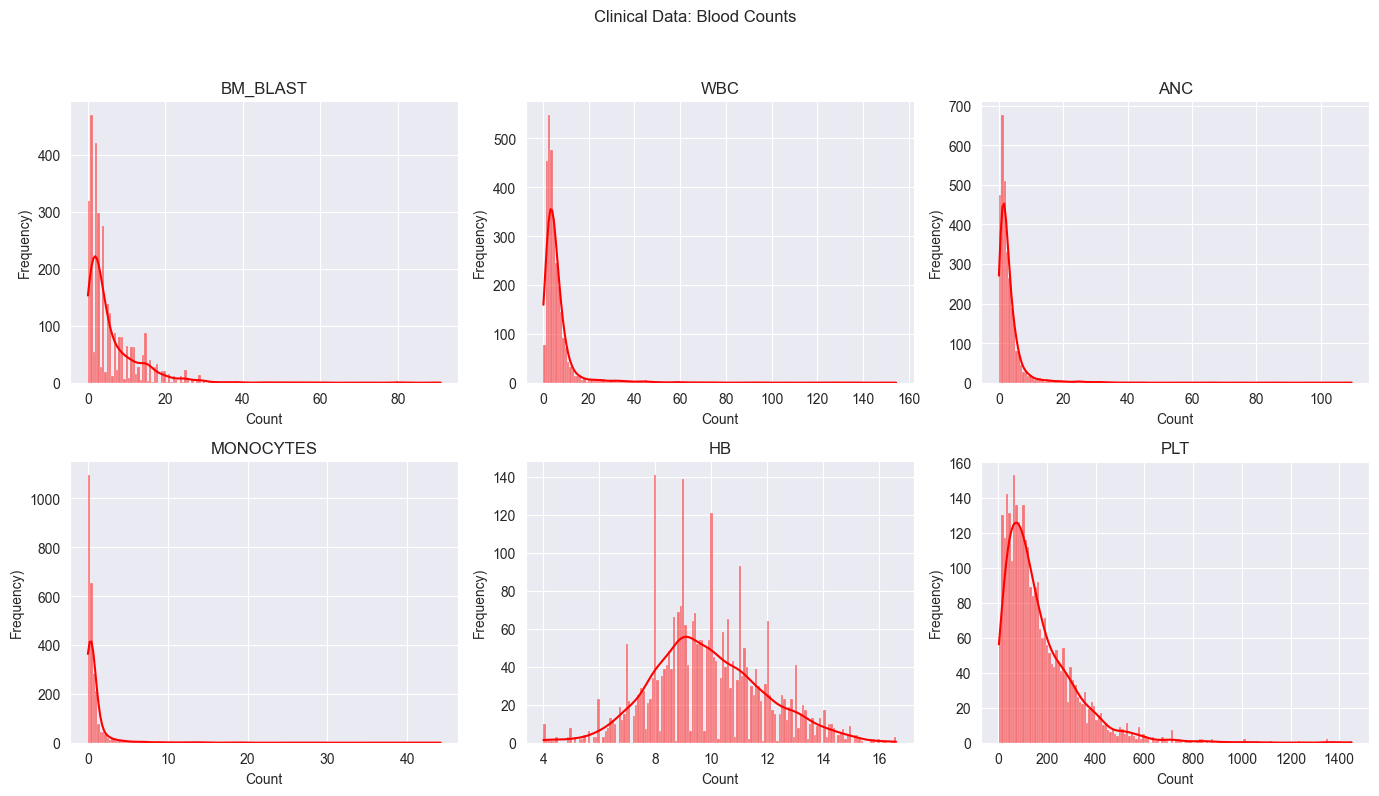

In [208]:
# BM_BLAST, WBC and ANC
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
fig.suptitle("Clinical Data: Blood Counts")

axes = axes.flatten()

for i, feature in enumerate(features):  # first 3 features
    ax = axes[i]
    sns.histplot(X[feature], ax=ax, bins=150, kde=True, color="red")
    ax.set_xlabel(f"Count")
    ax.set_title(f"{feature}")
    ax.set_ylabel("Frequency)")

plt.tight_layout(rect=[0, 0.1, 1, 0.95]);
plt.show();

In [218]:
os_fig = plt.figure(figsize=(6, 4))
sns.histplot(y[y['OS_STATUS'] == 0]['OS_YEARS'], bins=150, kde=True, color="blue", label='Alive since last check up')
sns.histplot(y[y['OS_STATUS'] == 1]['OS_YEARS'], bins=150, kde=True, color="red", alpha=.7, label='Deceased')
plt.xlabel("Overall survival in years")
plt.ylabel("Frequency")
plt.title("Distribution of OS_YEARS")
plt.legend();
plt.show()

BM_BLAST      79
WBC          229
ANC          141
MONOCYTES    544
HB            75
PLT           86
dtype: int64

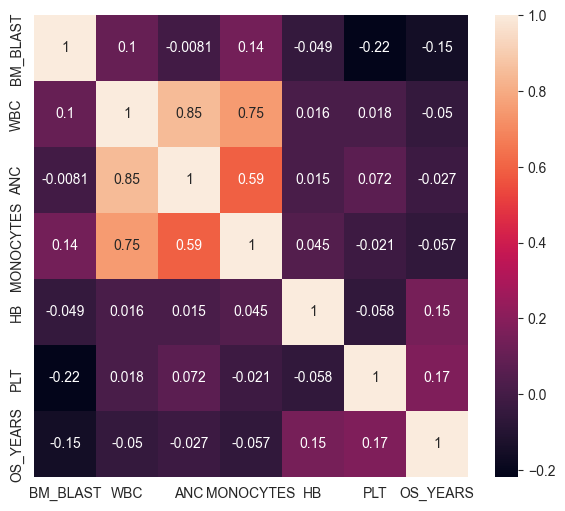

In [210]:
# Visualising the correlation between survival time and variables
fig_hm = plt.figure(figsize=(7,6))
temp = pd.concat((X, target_train['OS_YEARS']), axis=1)
heatmap = sns.heatmap(temp.corr(), annot=True)

# Feature engineering (Clinical Data Only)

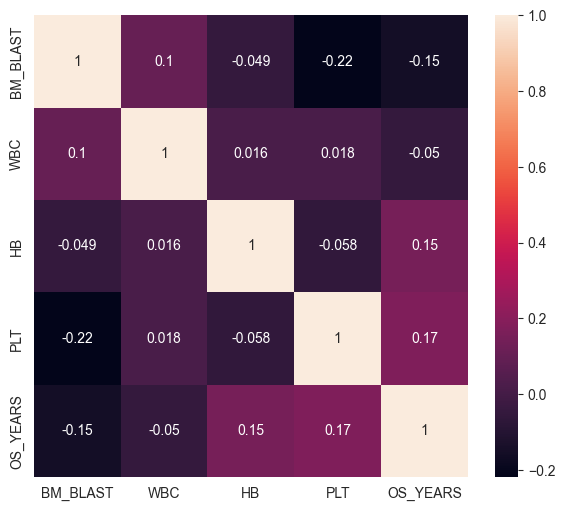

In [211]:
# Removing variables with high correlation to avoid collinearity (not necessarily a problem for XGBoost, but good to do it anyway)
features = ['BM_BLAST', 'WBC', 'HB', 'PLT']  # get rid of ANC or WBC,
X = c_train.loc[c_train['ID'].isin(target_train['ID']), features]

# New heatmap
fig_hm = plt.figure(figsize=(7,6))
temp = pd.concat((X, target_train['OS_YEARS']), axis=1)
heatmap = sns.heatmap(temp.corr(), annot=True)

np.int64(79)

# Box-Cox transform on right-skewed data
Observing the 6 distribution plots above, we can see that 5 of the 6 quantities are highly right-skewed so we will Box-Cox transform all of them.

In [212]:
rs_features = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'PLT']
X['BM_BLAST'], lambda_bmbl = stats.boxcox(X['BM_BLAST'] + 1)
X['WBC'], lambda_wbc = stats.boxcox(X['WBC'] + 1)
X['ANC'], lambda_anc = stats.boxcox(X['ANC'] + 1)
X['MONOCYTES'], lambda_mono = stats.boxcox(X['MONOCYTES'] + 1)
X['PLT'], lambda_plt = stats.boxcox(X['PLT'] + 1)



ValueError: The `x` argument of `boxcox_normmax` must contain only positive, finite, real numbers.

# Imputing clinical data with SimpleImputer
## 1. Train-test split



In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 35% test split

## 2. SimpleImputer

In [178]:
imputer = SimpleImputer(strategy="median")
X_train[features] = imputer.fit_transform(X_train[features])
X_test[features] = imputer.transform(X_test[features])

XGBoost Survival Model Concordance Index IPCW on train: 0.35
XGBoost Survival Model Concordance Index IPCW on test: 0.36
LightGBM Survival Model Concordance Index IPCW on train: 0.69
LightGBM Survival Model Concordance Index IPCW on test: 0.66


## 3. Training the model, leveraging censored observations

In [219]:
# Preparing data for XGBoost model
X_train_xgb = X_train
y_train_trans = y_train['OS_YEARS']
y_test_trans = y_test['OS_YEARS']

# Applying BoxCox transform to OS_YEARS
y_train_trans, lambda_bc = stats.boxcox(y_train_trans + 1)
y_test_trans, lambda_test_bc = stats.boxcox(y_test_trans + 1)

# OS_STATUS weight function
w = 0.8 # weighting for deceased patients
weights = w * y_train['OS_STATUS'] + (1 - w)

# LightGBM dataset
X_train_lgb = X_train
X_lgb = lgb.Dataset(X_train_lgb, label=y_train_trans, weight=weights)

# LGBM model
params_lgbm = {'verbose': -1,
               'learning_rate': 0.1,
               'max_depth': 2}
lgbm = lgb.train(params=params_lgbm, train_set=X_lgb)

# LGBM predictions
pred_train_lgbm = -lgbm.predict(X_train)
pred_test_lgbm = -lgbm.predict(X_test)


# Creating D-matrices for survival model in XGB
dtrain = xgb.DMatrix(X_train, label=y_train_trans, weight=weights)
dtest = xgb.DMatrix(X_test, label=y_test_trans)

# survival bounds
dtrain.set_float_info("label_lower_bound", np.where(y_train['OS_STATUS'] == True, y_train_trans, 0))  # if patient still alive, lower bound for survival time is 0
dtrain.set_float_info("label_upper_bound", np.full_like(y_train_trans, np.inf))  # no upper bound on survival time

# Creating XGBoost survival model
params = {'verbosity': 0,
          'objective': 'survival:cox',
          'eval_metric': 'cox-nloglik',
          'alpha': 0.1,
          'lambda': 0.1,
          'max_depth': 2,
          'subsample': 0.8,
          'learning_rate': 0.01,
          'num_boost_round': 1000}

watchlist = [(dtrain, 'train'), (dtest, 'eval')]
xgbr = xgb.train(params, dtrain)

pred_train = -xgbr.predict(dtrain)
pred_test = -xgbr.predict(dtest)

# Performance metrics
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
train_ci_ipcw_lgbm = concordance_index_ipcw(y_train, y_train, pred_train_lgbm, tau=7)[0]
test_ci_ipcw_lgbm = concordance_index_ipcw(y_train, y_test, pred_test_lgbm, tau=7)[0]

print(f"XGBoost Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"XGBoost Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw_lgbm:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw_lgbm:.2f}")

ValueError: The `x` argument of `boxcox_normmax` must contain only positive, finite, real numbers.

In [ ]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=8)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=8)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0


## Molecular Data Analysis


In [ ]:
# Preview
m_train.head()

In [182]:
m_train.dtypes

In [ ]:
# Need to apply inverse Box-Cox since LightGBM was trained on transformed data
from scipy.special import inv_boxcox

# Submission file
test_predictions = lgbm.predict(c_test.loc[:, features])
survival_pred = inv_boxcox(test_predictions, lambda_bc)


submission = pd.Series(test_predictions, index=c_test['ID'], name='risk_score')

In [ ]:
submission.to_csv("./submission.csv")